In [1]:
%run SAT_help_functions.ipynb
%matplotlib inline

In [2]:
data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Evans2021/Rae2014/dataBySubject/sub"
sample_size = 34
correct = 'Correct'
corrects = [True, False]
cond = 'Cond' 
conds = ['Speed', 'Accuracy']
rt = 'Time'

In [3]:
def get_RT_quantile_sub(df, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):
    
    # RT quantiles
    #print(df)
    #print(correct)
    #print(corrects[0])
    df_cor = df.loc[df[correct]==corrects[0]]
    RT_cor_s = df_cor.loc[df_cor[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_cor_a = df_cor.loc[df_cor[cond]==conds[1]][rt].quantile(q=quantiles)
    
    df_err = df.loc[df[correct]==corrects[1]]
    RT_err_s = df_err.loc[df_err[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_err_a = df_err.loc[df_err[cond]==conds[1]][rt].quantile(q=quantiles)
    
    # number of trials
    num_cor_s = len(df_cor.loc[df_cor[cond]==conds[0]])
    num_cor_a = len(df_cor.loc[df_cor[cond]==conds[1]])

    num_err_s = len(df_err.loc[df_err[cond]==conds[0]])
    num_err_a = len(df_err.loc[df_err[cond]==conds[1]])
    
    return RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, [num_cor_s,num_cor_a,num_err_s,num_err_a]


In [4]:
def get_RT_quantile(data_dir, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        #print(i)
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        df = df[df["Time"]<5]

        #print(df)
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_sub(
            df = df, rt = rt,
            correct = correct, corrects = corrects,
            cond = cond, conds = conds)
        #print(RT_cor_s)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
        
        #print(RT_err_s)

    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, correct = correct, corrects = corrects,
        cond = cond, conds = conds, rt = rt)

In [5]:
get_RT_quantile(data_dir = data_dir,sample_size= sample_size, correct = correct, corrects = corrects,
        cond = cond, conds = conds, rt = rt)

(array([0.29582941, 0.35172647, 0.39210294, 0.44642353, 0.54403824]),
 array([0.35218529, 0.42074706, 0.4745    , 0.54365588, 0.66081765]),
 array([0.27926176, 0.33127647, 0.37083824, 0.41465588, 0.49814118]),
 array([0.31708529, 0.37568529, 0.42085294, 0.47724118, 0.59889706]),
 array([561.05882353, 635.29411765, 286.79411765, 221.79411765]))

In [6]:
#params = np.array(params_all)[0,1:6]
class DriftConstantSpeedAcc(Drift):
    name = "DriftConstantSpeedAcc"
    required_parameters = ["Vspeed","Vacc"]
    required_conditions = ['Cond']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['Cond'] == 'Speed':
            return self.Vspeed
        elif conditions['Cond'] == 'Accuracy':
            return self.Vacc
        else: 
            print("Non-implemented SAT conditions")
class DriftBothSpeedAcc(Drift):
    name = "DriftBothSpeedAcc"
    required_parameters = ["Vspeed","Vacc", "Kspeed", "Kacc"]
    required_conditions = ['Cond']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['Cond'] == 'Speed':
            return self.Vspeed + x*self.Kspeed 
        elif conditions['Cond'] == 'Accuracy':
            return self.Vacc + x*self.Kacc
        else: 
            print("Non-implemented SAT conditions")
class DriftExcitationSpeedAcc(Drift):
    name = "DriftSpeedAcc"
    required_parameters = ["drift", "Kspeed", "Kacc"]
    required_conditions = ['Cond']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['Cond'] == 'Speed':
            return self.drift + x*self.Kspeed 
        elif conditions['Cond'] == 'Accuracy':
            return self.drift + x*self.Kacc
        else: 
            print("Non-implemented SAT conditions")

class BoundSpeedAcc(Bound):
    name = "BoundSpeedAcc"
    required_parameters = ["Bspeed", "Bacc"]
    required_conditions = ['Cond']
    def get_bound(self, conditions, *args, **kwargs):
        assert self.Bacc > 0
        assert self.Bspeed > 0
        if conditions['Cond'] == 'Speed':
            return self.Bspeed
        elif conditions['Cond'] == 'Accuracy':
            return self.Bacc
        else:
            print("Non-implemented SAT conditions")
            
class NondecisionSpeedAcc(OverlayNonDecision):
    name = "NondecisionSpeedAcc"
    required_parameters = ["tSpeed", 'tAcc']
    required_conditions = ['Cond']
        
    def get_nondecision_time(self, conditions, **kwargs):
        if conditions['Cond'] == 'Speed':
            return self.tSpeed 
        elif conditions['Cond'] == 'Accuracy':
            return self.tAcc
        else: 
            print("Non-implemented SAT conditions")
            
def get_RT_quantile_DDM_sub(params, T_dur=5):

    Vspeed,Vacc, Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]
    
    model = Model(name='Simple model (fitted)',
                      drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc), 
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))

    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', conds, 'RT')
#get_RT_quantile_DDM_sub(params = np.array(params_all)[3,1:6])

In [7]:
#np.array(params_all)[3,1:6]

In [7]:
def get_RT_quantile_DDM(params_all, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        #print(i)
        params = np.array(params_all)[i,1:7]
        
        
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM_sub(params = params)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

In [8]:

model = 'DDM2v2a2ter'
dataset = 'Rae2014'
params_all = pd.read_csv(model+"result"+dataset+".csv")# .drop(labels=3, axis=0)

<Axes: xlabel='Probability of Response', ylabel='RT'>

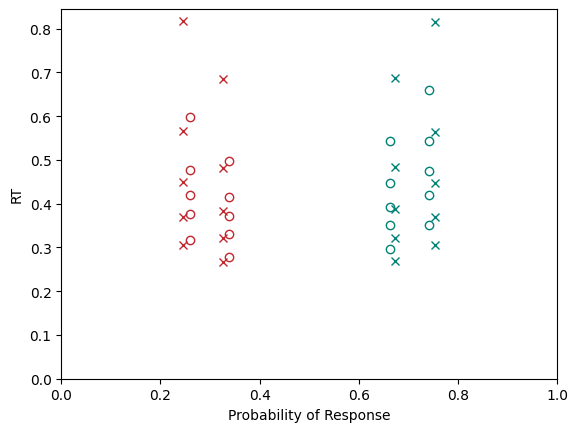

In [9]:
def DDM_QP_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = '#c1272d', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(params_all = params_all,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)
DDM_QP_plot()

In [159]:
params_all = pd.read_csv("OUM2v2k2terresultRae2014_medium_k_0_ter.csv")
params_all

,Unnamed: 0,Drift Rate Speed,Drift Rate Accuracy,Self-excitation Speed,Self-excitation Accuracy,Boundary Separation,Non-decision Time Speed,Non-decision Time Accuracy,BIC
0,0,1.365793,2.028611,8.000000,6.762886,1.840181,0.171109,0.258909,-1157.197221
1,0,1.054167,2.048577,8.000000,8.000000,1.032844,0.213282,0.293032,-2123.302963
2,0,0.176271,0.319258,8.000000,8.000000,1.981189,0.061632,0.119484,-401.151997
3,0,2.486204,2.719591,8.000000,8.000000,0.695011,0.282636,0.301585,-3779.773699
4,0,0.318206,0.580700,8.000000,8.000000,1.886228,0.079127,0.125808,-234.481527
5,0,2.108882,2.586526,8.000000,8.000000,0.780613,0.245869,0.278409,-1738.423912
6,0,1.713056,2.077811,8.000000,8.000000,0.660819,0.270608,0.319135,-2726.625005
7,0,1.894479,1.806398,8.000000,2.146153,0.701930,0.243293,0.276359,-1893.094805
8,0,1.871511,2.315570,8.000000,8.000000,1.034612,0.263049,0.296918,-1348.894221
9,0,1.256981,1.738957,8.000000,8.000000,0.940193,0.213923,0.250708,-1955.834294


In [149]:
params_all = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
params_all                                               

,Unnamed: 0,Drift Rate Speed,Drift Rate Accuracy,Boundary Separation Speed,Boundary Separation Accuracy,Non-decision Time Speed,Non-decision Time Accuracy,BIC
0,0,1.504859,1.886526,0.576637,0.656681,0.237687,0.306286,-450.008495
1,0,1.116110,1.914780,0.502713,0.527989,0.235553,0.304942,-1237.083073
2,0,0.328112,0.460104,0.500000,0.560953,0.168394,0.164999,512.828696
3,0,2.447997,2.648451,0.500000,0.506178,0.285134,0.304548,-3393.881196
4,0,0.516938,0.764096,0.500000,0.574915,0.162094,0.163052,176.278432
5,0,2.057956,2.420889,0.506114,0.504998,0.242573,0.271047,-1411.316126
6,0,1.781678,2.100484,0.500000,0.500000,0.275382,0.314031,-2180.731434
7,0,1.908281,1.829279,0.500000,0.671241,0.245402,0.269043,-1516.939733
8,0,1.702736,2.157449,0.525980,0.570223,0.277668,0.290263,-950.621756
9,0,1.418551,1.750401,0.500000,0.514887,0.241074,0.276327,-1317.734725


In [150]:
pd.read_csv("OUM2v2k2terresultRae2014_medium_k.csv")


,Unnamed: 0,Drift Rate Speed,Drift Rate Accuracy,Self-excitation Speed,Self-excitation Accuracy,Boundary Separation,Non-decision Time Speed,Non-decision Time Accuracy,BIC
0,0,1.360621,2.037806,8.0,8.0,2.446343,0.143138,0.246522,-1133.584169
1,0,1.074829,2.096226,8.0,8.0,1.077071,0.213283,0.290316,-2119.296465
2,0,0.198135,0.331209,8.0,8.0,1.489758,0.102611,0.143209,-386.306667
3,0,2.506941,2.743515,8.0,8.0,0.707146,0.285854,0.304955,-3780.001075
4,0,0.345581,0.585621,8.0,8.0,1.526027,0.109478,0.142599,-228.861301
5,0,2.108878,2.586520,8.0,8.0,0.786959,0.242596,0.273232,-1738.423912
6,0,1.713055,2.077814,8.0,8.0,0.660298,0.274728,0.313197,-2726.625005
7,0,1.823740,1.727872,8.0,8.0,0.981507,0.217914,0.270064,-1560.219750
8,0,1.860404,2.301726,8.0,8.0,1.025846,0.268303,0.296553,-1348.851172
9,0,1.243470,1.718672,8.0,8.0,0.920470,0.211473,0.258496,-1957.831247


In [131]:
params_all = pd.read_csv(model+"result"+dataset+".csv")#.drop(labels=3, axis=0)
params_all

,Unnamed: 0,Drift Rate Speed,Drift Rate Accuracy,Self-excitation Speed,Self-excitation Accuracy,Boundary Separation,Non-decision Time Speed,Non-decision Time Accuracy,BIC
0,0,1.372909,2.019786,8.474859,6.839742,2.019262,0.177604,0.240258,-1159.528184
1,0,1.017757,1.915763,10.000000,10.000000,1.854995,0.184004,0.257896,-2310.386945
2,0,0.203779,0.348028,8.430457,8.412920,1.607034,0.105605,0.143404,-417.082496
3,0,2.503166,2.761246,10.000000,10.000000,0.796439,0.287013,0.305699,-3834.931049
4,0,0.297667,0.562280,10.000000,8.982340,2.007460,0.102939,0.131076,-274.053801
5,0,2.109487,2.626961,10.000000,10.000000,0.921633,0.240498,0.277386,-1791.595632
6,0,1.573347,1.948520,10.000000,10.000000,1.329374,0.223486,0.263984,-2854.939886
7,0,1.853664,1.855056,9.855698,3.108662,0.771860,0.243735,0.272186,-1973.523788
8,0,1.856340,2.295597,10.000000,10.000000,1.373132,0.258329,0.285238,-1405.398684
9,0,1.080440,1.782420,10.000000,10.000000,1.548995,0.179951,0.232211,-2066.198350


In [92]:
#params = np.array(params_all)[0,1:8]


In [10]:
def get_RT_quantile_OUM2v2k2ter_sub(params, T_dur=5):

    Vspeed,Vacc, Kspeed,Kacc,B,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6]

    model = Model(name='Simple model (fitted)',
                      drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=B),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))
    #print(data)
    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', conds, 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

## Full OUM model

In [51]:
params_all = pd.read_csv("OUMfullresultRae2014.csv")
params_all

,Unnamed: 0,Drift Rate Speed,Drift Rate Accuracy,Self-excitation Speed,Self-excitation Accuracy,Boundary Separation Speed,Boundary Separation Accuracy,Non-decision Time Speed,Non-decision Time Accuracy,BIC
0,0,1.390043,2.051663,9.660486,7.551595,5.188237,2.983399,0.101541,0.217781,-1151.205986
1,0,1.061502,1.981157,10.000000,10.000000,1.361987,2.191239,0.216509,0.241131,-2316.066149
2,0,0.191958,0.289179,8.414038,8.850470,1.579922,2.628269,0.105359,0.107431,-451.476052
3,0,2.485757,2.701438,10.000000,10.000000,0.787311,1.335313,0.286908,0.262933,-3819.681822
4,0,0.294182,0.549650,10.000000,9.914605,1.967047,3.331974,0.106436,0.107527,-283.205840
5,0,2.097140,2.526638,10.000000,10.000000,0.919617,0.867108,0.244905,0.274159,-1784.549703
6,0,1.683754,1.974791,10.000000,10.000000,0.731542,1.356874,0.272441,0.262977,-2896.918550
7,0,1.834368,1.830363,9.912589,3.199537,0.781981,0.790005,0.247522,0.272885,-1965.198960
8,0,1.886056,2.346585,10.000000,10.000000,1.094114,1.424737,0.277693,0.289014,-1402.996363
9,0,1.112802,1.769628,10.000000,9.519694,1.625365,1.122361,0.173525,0.253612,-2081.935242


In [12]:
def get_RT_quantile_OUMfull_sub(params, T_dur=5):

    Vspeed,Vacc, Kspeed,Kacc,Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7]

    model = Model(name='Simple model (fitted)',
                      drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))
    #print(data)
    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', conds, 'RT')
#get_RT_quantile_OUMfull_sub(params = np.array(params_all)[0,1:9])

In [56]:
#np.array(params_all)[0,1:8]

In [13]:
def get_RT_quantile_OUMfull(params_all, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):

        params = np.array(params_all)[i,1:9]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUMfull_sub(params = params)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        #print(RT_cor_as)
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUMfull(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
        cond = cond, conds = conds, rt = rt)

IndexError: index 7 is out of bounds for axis 0 with size 7

In [63]:
def OUMfull_QP_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = '#c1272d', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUMfull(params_all = params_all,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)


<Axes: xlabel='Probability of Response', ylabel='RT'>

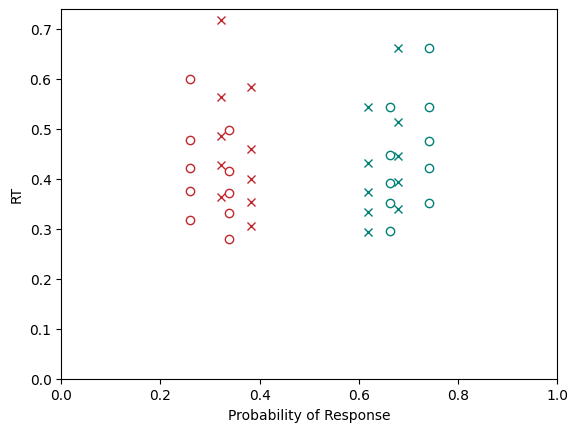

In [64]:
OUMfull_QP_plot()

## OUM2v2k2ter

In [14]:
def get_RT_quantile_OUM2v2k2ter(params_all, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):

        params = np.array(params_all)[i,1:8]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2k2ter_sub(params = params)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

In [15]:
def OUM2v2k2ter_QP_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = '#c1272d', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)


In [160]:
params_all = pd.read_csv("OUM2v2k2terresultRae2014_remove_0.2s_trials_large_k.csv")


In [ ]:
model = 'OUM2v2k2ter'
dataset = 'Rae2014'
params_all = pd.read_csv(model+"result"+dataset+".csv")#.drop(labels=3, axis=0)
params_all = pd.read_csv("OUM2v2k2terresultRae2014_large_k.csv")
params_all = pd.read_csv("OUM2v2k2terresultRae2014_remove_0.2s_trials.csv")
params_all = pd.read_csv("OUM2v2k2terresultRae2014_remove_0.2s_trials_large_k.csv")
params_all = pd.read_csv("OUM2v2k2terresultRae2014_small_k.csv")

params_all = pd.read_csv("OUM2v2k2terresultRae2014_medium_k.csv")


<Axes: xlabel='Probability of Response', ylabel='RT'>

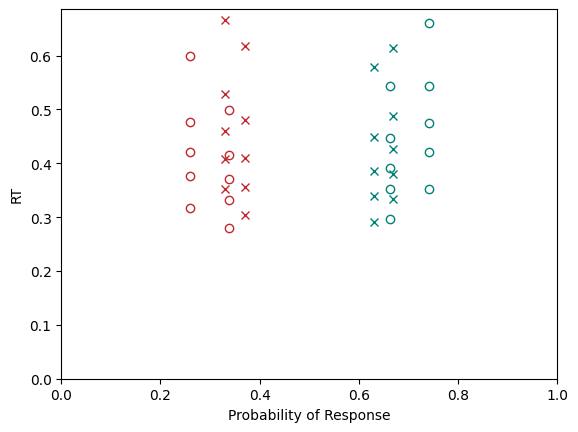

In [162]:
params_all = pd.read_csv("OUM2v2k2terresultRae2014_medium_k.csv")

OUM2v2k2ter_QP_plot()

In [16]:
def DDM_OUM_QP_sub_plot(dataset, data_dir,sample_size, 
                        correct, corrects,
                        cond, conds, rt, sub,
                        ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = RT_cor_s[sub,:], RT_cor_a[sub,:], RT_err_s[sub,:], RT_err_a[sub,:], nums[sub,:]
    #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from DDM
    params_DDM = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_DDM(params_all = params_DDM,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = RT_cor_s[sub,:], RT_cor_a[sub,:], RT_err_s[sub,:], RT_err_a[sub,:], nums[sub,:]
    #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)

    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#008176', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#008176', fillstyle = 'none')
    
    ## data generated from OUM
    params_OUM = pd.read_csv("OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_OUM2v2k2ter(params_all = params_OUM,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = RT_cor_s[sub,:], RT_cor_a[sub,:], RT_err_s[sub,:], RT_err_a[sub,:], nums[sub,:]
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
    ax.set_title("BIC Difference: "+str(params_DDM["BIC"][sub]-params_OUM["BIC"][sub]))
    #ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    #ax.legend(loc = 'upper right')
    return(ax)
#DDM_OUM_QP_plot(dataset)

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))
DDM_SAT_plot(ax=axes[0])
OUM_SAT_plot(ax=axes[1])

[0.363 0.417 0.47  0.524 0.598] [0.435 0.491 0.542 0.58  0.723] [0.308  0.3639 0.417  0.488  0.597 ] [0.4002 0.453  0.508  0.6408 1.016 ] [913. 989. 204. 123.]
[0.31452662 0.36838182 0.43868788 0.52829878 0.74999705] [0.39599405 0.46361219 0.53504091 0.65406545 0.87133873] [0.29963178 0.36170033 0.44559786 0.54356403 0.72988407] [0.40353095 0.48786767 0.55332631 0.64241128 0.86794339] [848. 934. 152.  66.]
[0.346 0.399 0.435 0.471 0.527] [0.417  0.453  0.489  0.525  0.5911] [0.327  0.3714 0.4    0.435  0.49  ] [0.363  0.4171 0.454  0.508  0.6176] [808. 952. 309. 168.]
[0.29874591 0.34682796 0.41404813 0.50599015 0.70530114] [0.36445812 0.41339871 0.46119001 0.54603608 0.73747438] [0.29799    0.3357275  0.38710179 0.48054543 0.69611557] [0.39096543 0.44625135 0.50754649 0.59819338 0.76286133] [760. 876. 240. 124.]
[0.273 0.345 0.381 0.435 0.507] [0.327 0.398 0.436 0.489 0.562] [0.2378 0.309  0.363  0.399  0.454 ] [0.29  0.363 0.4   0.449 0.525] [601. 661. 449. 415.]
[0.23929545 0.290677

[0.23   0.2955 0.33   0.396  0.493 ] [0.232 0.328 0.365 0.459 0.558] [0.2301 0.2754 0.329  0.363  0.4552] [0.231  0.296  0.331  0.3941 0.459 ] [586. 571. 472. 484.]
[0.23745898 0.28334233 0.35302631 0.45423849 0.66561058] [0.22200052 0.28300765 0.34638014 0.44339762 0.62300288] [0.23635307 0.29748308 0.37388093 0.46847529 0.66948228] [0.22968354 0.27452818 0.32145468 0.42840221 0.65011725] [546. 578. 454. 422.]
[0.296  0.393  0.458  0.525  0.6527] [0.363  0.4893 0.557  0.653  0.782 ] [0.264 0.33  0.393 0.427 0.525] [0.296  0.363  0.429  0.49   0.5871] [684. 842. 423. 270.]
[0.2519295  0.31260584 0.39638946 0.51564172 0.74235446] [0.30037755 0.38684322 0.48551189 0.61267754 0.99135951] [0.25162157 0.30524746 0.37991881 0.47199631 0.74901224] [0.29218868 0.38121654 0.48004273 0.62916234 0.99134697] [584. 802. 416. 198.]
[0.2   0.262 0.265 0.329 0.46 ] [0.233  0.296  0.362  0.4916 0.623 ] [0.2015 0.233  0.295  0.328  0.426 ] [0.231 0.296 0.329 0.397 0.523] [526. 609. 526. 489.]
[0.2221782

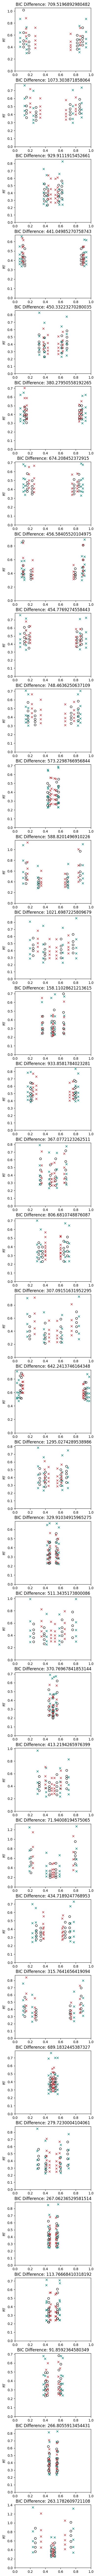

In [146]:
fig, ax = plt.subplots(sample_size,figsize=(4, 4*sample_size))

for i in range(sample_size): #sample_size
    DDM_OUM_QP_sub_plot(dataset, data_dir,sample_size, 
                        correct, corrects,
                        cond, conds, rt, sub=i, ax = ax[i])

[0.363 0.417 0.47  0.524 0.598] [0.435 0.491 0.542 0.58  0.723] [0.308  0.3639 0.417  0.488  0.597 ] [0.4002 0.453  0.508  0.6408 1.016 ] [913. 989. 204. 123.]
[0.31088353 0.37208736 0.44997135 0.56152021 0.782866  ] [0.39328029 0.45910978 0.53518882 0.63538064 0.86825194] [0.32332576 0.38861573 0.48387025 0.59565516 0.86357962] [0.39755167 0.44969966 0.55555503 0.64027669 0.80999746] [844. 924. 156.  76.]


<Axes: title={'center': 'BIC Difference: 709.5196892980482'}, xlabel='Probability of Response', ylabel='RT'>

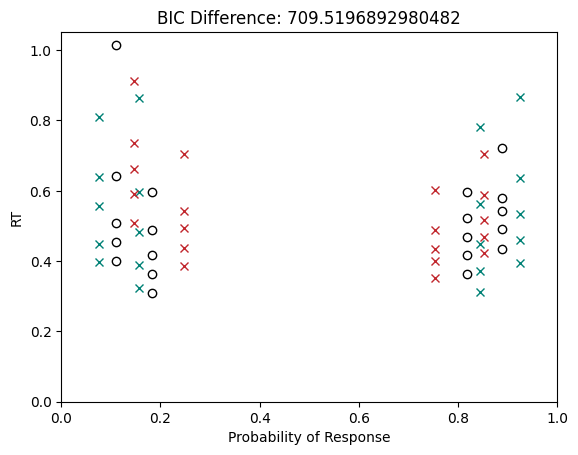

In [138]:
DDM_OUM_QP_sub_plot(dataset, data_dir = data_dir,sample_size= sample_size, 
                    correct = correct, corrects = corrects,
                    cond = cond, conds = conds, rt = rt,sub = 0)

<Axes: xlabel='Probability of Response', ylabel='RT'>

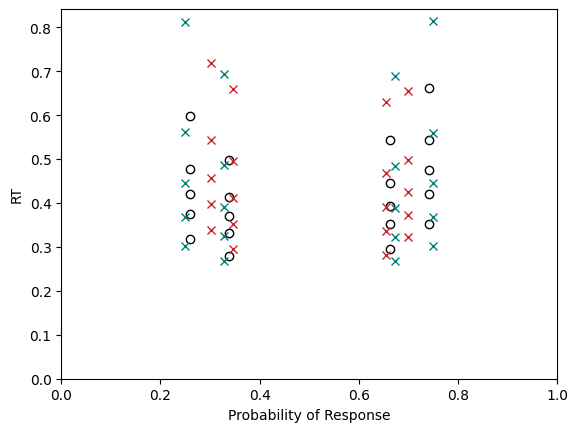

In [157]:
DDM_OUM_QP_plot(dataset, data_dir = data_dir,sample_size= sample_size, 
                   correct = correct, corrects = corrects,
                   cond = cond, conds = conds, rt = rt)

array([<Axes: title={'center': 'Correct Choices'}, xlabel='0.9 Quantile of DDM', ylabel='0.9 Quantile of OUM'>,
       <Axes: title={'center': 'Incorrect Choices'}, xlabel='0.9 Quantile of DDM'>],
      dtype=object)

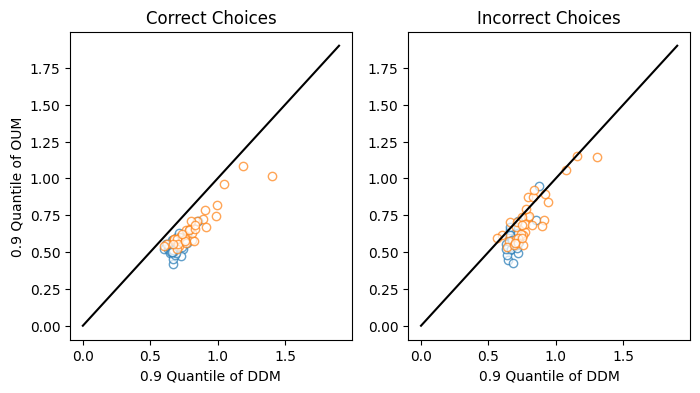

In [50]:
%run SAT_help_functions.ipynb

DDM_OUM_09quantile_plot(dataset, data_dir,sample_size, correct, corrects,
                            cond, conds, rt,legend = None)

In [67]:
%run SAT_help_functions.ipynb

## data generated from DDM
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_data = pd.DataFrame({"cor_s":RT_cor_s[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,4]/RT_cor_a[:,2], "err_s": RT_err_s[:,4]/RT_err_s[:,2],'err_a': RT_err_a[:,4]/RT_err_a[:,2]})

## data generated from DDM
params_DDM = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_DDM(params_all = params_DDM,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_DDM = pd.DataFrame({"cor_s":RT_cor_s[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,4]/RT_cor_a[:,2], "err_s": RT_err_s[:,4]/RT_err_s[:,2],'err_a': RT_err_a[:,4]/RT_err_a[:,2]})

## data generated from OUM
params_OUM = pd.read_csv("OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_OUM2v2k2ter(params_all = params_OUM,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_OUM = pd.DataFrame({"cor_s":RT_cor_s[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,4]/RT_cor_a[:,2], "err_s": RT_err_s[:,4]/RT_err_s[:,2],'err_a': RT_err_a[:,4]/RT_err_a[:,2]})


In [57]:
quantiles_data.to_csv("quantiles_data_"+dataset)
quantiles_DDM.to_csv("quantiles_DDM_"  +dataset)
quantiles_OUM.to_csv("quantiles_OUM_"  +dataset)


In [53]:
%run SAT_help_functions.ipynb

model = 'DDM2v2a2ter'
params_all = pd.read_csv(model+"result"+dataset+".csv")# .drop(labels=3, axis=0)
ks_DDM = get_ks_DDM(params_all, sample_size, cond, conds)

model = 'OUM2v2k2ter'
params_all = pd.read_csv(model+"result"+dataset+".csv")#.drop(labels=3, axis=0)
ks_OUM = get_ks_OUM(params_all, sample_size, cond, conds)

<Axes: title={'center': 'Incorrect Choices'}, xlabel='K-S Statistic of DDM'>

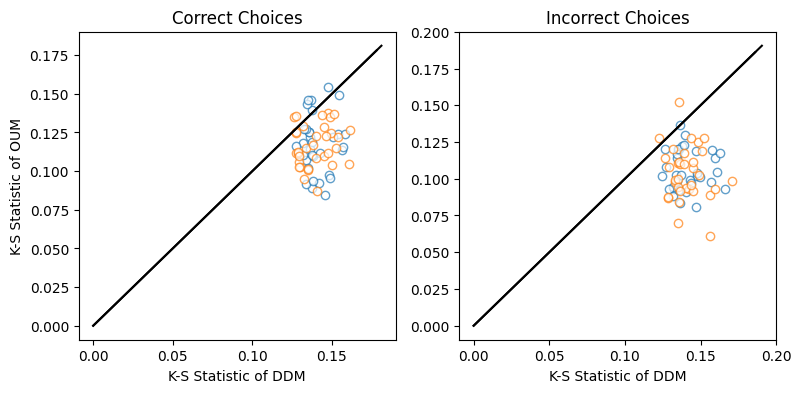

In [55]:

%run SAT_help_functions.ipynb
fig, axes = plt.subplots(1,2,figsize=(9, 4))
plot_normality_correct(ks_DDM,ks_OUM, ax=axes[0])
plot_normality_error(ks_DDM,ks_OUM, ax=axes[1])

In [58]:
%run SAT_help_functions.ipynb
ks_data = get_ks_data(data_dir, sample_size, correct, corrects, cond, conds, rt)

model = 'DDM2v2a2ter'
#dataset = 'Dutilh2013'
params_all = pd.read_csv(model+"result"+dataset+".csv")# .drop(labels=3, axis=0)
ks_DDM = get_ks_DDM(params_all, sample_size, cond, conds)

model = 'OUM2v2k2ter'
#dataset = 'Dutilh2013'
params_all = pd.read_csv(model+"result"+dataset+".csv")#.drop(labels=3, axis=0)
ks_OUM = get_ks_OUM(params_all, sample_size, cond, conds)

In [59]:
ks_data.to_csv("ks_data_"+dataset)
ks_DDM.to_csv("ks_DDM_"  +dataset)
ks_OUM.to_csv("ks_OUM_"  +dataset)


In [7]:

%run SAT_help_functions.ipynb
ks_data = get_ks_data(data_dir, sample_size, correct, corrects, cond, conds, rt)
dataset = 'Rae2014'

model = 'DDM2v2a2ter'
params_all = pd.read_csv(model+"result"+dataset+".csv")# .drop(labels=3, axis=0)
ks_DDM = get_ks_DDM_matched(params_all, sample_size, cond, conds)

model = 'OUM2v2k2ter'
params_all = pd.read_csv(model+"result"+dataset+".csv")#.drop(labels=3, axis=0)
ks_OUM = get_ks_OUM_matched(params_all, sample_size, cond, conds)

ks_DDM.to_csv("ks_DDM_matched_"  +dataset)
ks_OUM.to_csv("ks_OUM_matched_"  +dataset)


### 0.1 quantiles

In [17]:
## data generated from DDM
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_data = pd.DataFrame({"cor_s":RT_cor_s[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,0]/RT_cor_a[:,2], "err_s": RT_err_s[:,0]/RT_err_s[:,2],'err_a': RT_err_a[:,0]/RT_err_a[:,2]})

## data generated from DDM
params_DDM = pd.read_csv("DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_DDM(params_all = params_DDM,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_DDM = pd.DataFrame({"cor_s":RT_cor_s[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,0]/RT_cor_a[:,2], "err_s": RT_err_s[:,0]/RT_err_s[:,2],'err_a': RT_err_a[:,0]/RT_err_a[:,2]})

## data generated from OUM
params_OUM = pd.read_csv("OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile_OUM2v2k2ter(params_all = params_OUM,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_OUM = pd.DataFrame({"cor_s":RT_cor_s[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,0]/RT_cor_a[:,2], "err_s": RT_err_s[:,0]/RT_err_s[:,2],'err_a': RT_err_a[:,0]/RT_err_a[:,2]})




In [18]:
quantiles_data.to_csv("1quantiles_data_"+dataset)
quantiles_DDM.to_csv("1quantiles_DDM_"  +dataset)
quantiles_OUM.to_csv("1quantiles_OUM_"  +dataset)